In [1]:
#!/usr/bin/python

import sys
import pickle
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

In [2]:
### Load the dictionary containing the dataset
# pickle compatible with python3
with open("final_project_dataset_python3.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

## Explorando os dados

### Análise das Características e Remoção de Outliers

Para manter os dados ainda compatíveis com o `tester.py` na análise será
realizado sobre um dataframe, porém posteriormente será aplicado os ajustes
no dicionário.

In [3]:
data_df = pd.DataFrame.from_dict(data_dict).T
print(data_df.dtypes.value_counts())

object    21
dtype: int64


Todos os campos são importados como strings, assim para uma avaliação dos
outliers primeiro temos que converter os campos para numéricos.

In [4]:
# seleciona as colunas que não são numéricas
cols_string = ['email_address', 'poi']
cols = list(data_df)

# seleciona as variáveis numéricas
cols_numeric = np.setdiff1d(cols, cols_string)

# transforma os valores em números e quando 'NaN' em NaN
data_df[cols_numeric] = data_df[cols_numeric].apply(pd.to_numeric, errors='coerce')
data_df['poi'] = data_df['poi'].astype('bool')

# sumário dos dados transposto para melhor visualização
print(data_df.describe().T[['count', 'min', 'mean', 'max']])

                           count         min          mean          max
bonus                       82.0     70000.0  2.374235e+06   97343619.0
deferral_payments           39.0   -102500.0  1.642674e+06   32083396.0
deferred_income             49.0 -27992891.0 -1.140475e+06       -833.0
director_fees               17.0      3285.0  1.668049e+05    1398517.0
exercised_stock_options    102.0      3285.0  5.987054e+06  311764000.0
expenses                    95.0       148.0  1.087289e+05    5235198.0
from_messages               86.0        12.0  6.087907e+02      14368.0
from_poi_to_this_person     86.0         0.0  6.489535e+01        528.0
from_this_person_to_poi     86.0         0.0  4.123256e+01        609.0
loan_advances                4.0    400000.0  4.196250e+07   83925000.0
long_term_incentive         66.0     69223.0  1.470361e+06   48521928.0
other                       93.0         2.0  9.190650e+05   42667589.0
restricted_stock           110.0  -2604490.0  2.321741e+06  1303

Pode ser notado que algumas das variáveis não podemos utilizar pela grande
quantidade de informação faltando. Isso ocorre principalmente para as
variáveis `director_fees`, `loan_advances` e `restricted_stock_deferred`

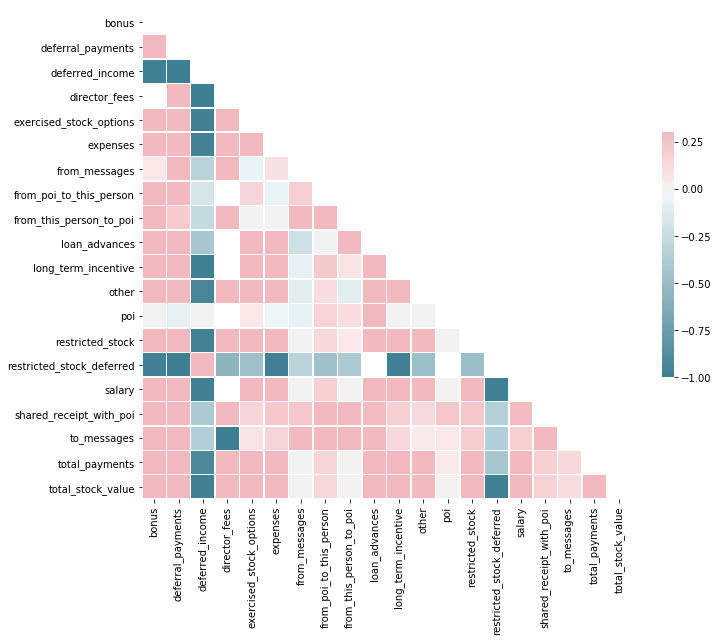

In [5]:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html

corr = data_df.corr()

# cria uma mascara para o triangulo superior
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# configura o plt
f, ax = plt.subplots(figsize=(11, 9))

# cria as cores para as relações
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# desenha o grafico com a relação de cores associadas com a correlação
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [6]:
def tag_outlier(df, columns):
    """ Identifica possíveis outliers, colocado um range maior
        para um outlier visto que os dados possuem uma grande 
        variância, e a identificação de poi esta associada a 
        valores extremos.
    Args:
        variable: pandas dataframe
    Returns:
        row index
    Raises:
    """
    def column_outlier_eval(variable):
        q1, q3 = variable.quantile([.25, .75])
        inter_q = q3 - q1
        max_val = q3 + 5 * inter_q
        min_val = q1 - 5 * inter_q
        return variable[(variable > max_val) | (variable < min_val)].index

    rows_to_look = []
    for var in columns:
        rows_to_look.append(list(column_outlier_eval(df[var])))

    possible_outlier = np.unique([j for i in rows_to_look for j in i])
    return possible_outlier

def too_many_nan(df, qty_limit):
    """ Identifica as linhas com muitos NaN
    Args:
        variable: pandas dataframe
    Returns:
        row index
    Raises:
    """
    qty_nan = df.isnull().sum(axis=1)
    print(qty_nan.loc[qty_nan > qty_limit].sort_values())
    

In [7]:
tag_outlier(data_df, cols_numeric)
too_many_nan(data_df, 16)

GRAMM WENDY L                    17
SCRIMSHAW MATTHEW                17
THE TRAVEL AGENCY IN THE PARK    17
WHALEY DAVID A                   17
WODRASKA JOHN                    17
WROBEL BRUCE                     17
LOCKHART EUGENE E                19
dtype: int64


In [8]:
print(data_df.loc['LOCKHART EUGENE E'])

bonus                          NaN
deferral_payments              NaN
deferred_income                NaN
director_fees                  NaN
email_address                  NaN
exercised_stock_options        NaN
expenses                       NaN
from_messages                  NaN
from_poi_to_this_person        NaN
from_this_person_to_poi        NaN
loan_advances                  NaN
long_term_incentive            NaN
other                          NaN
poi                          False
restricted_stock               NaN
restricted_stock_deferred      NaN
salary                         NaN
shared_receipt_with_poi        NaN
to_messages                    NaN
total_payments                 NaN
total_stock_value              NaN
Name: LOCKHART EUGENE E, dtype: object


Observando os dados podemos observar o aparecimento de uma pessoa chamada
`TOTAL` o que nos aponta para um povável erro de digitação que podemos
eliminar dos dados.

Outro ponto é o aparecimento de uma agencia de viagens nos dados
`THE TRAVEL AGENCY IN THE PARK` que ao não representar uma pessoa será removido.

Por ultimo temos uma pessoa chamada `LOCKHART EUGENE E` que não possuímos
nenhuma informação referente, assim também será removido.

In [9]:
items_to_drop = ['TOTAL','THE TRAVEL AGENCY IN THE PARK', 'LOCKHART EUGENE E']
for outlier in items_to_drop:
    data_dict.pop(outlier, 0)
    
data_df.drop(items_to_drop, inplace=True)

### Criação de Novas Variáveis

Para a criação de novas variáveis será utilizado a relação entre a quantidade
de emails enviadas para `poi` e a quantidade total de emails enviada por cada
pessoa.

In [10]:
if_nan_make_zero = lambda x : 0 if x == 'NaN' else x 

for poi in data_dict:
    if data_dict[poi]['to_messages'] == 'NaN':
        data_dict[poi]['msg_to_poi_prec'] = 0
    else:
        data_dict[poi]['msg_to_poi_prec'] = if_nan_make_zero(data_dict[poi]['from_this_person_to_poi']) / \
                                if_nan_make_zero(data_dict[poi]['to_messages'])

### Avaliação das Variáveis


Primeiro vamos avaliar as variáveis disponiveis pelo score relativo ao `poi`. 
Isso é feito utilizando o `SelectBest` e observando o score obtido pelo `fit`
do modelo.

In [11]:
# seleciona as colunas que não são numéricas
cols_remove = ['email_address', 'poi']
cols = list(data_df)

# de todas as colunas, selecionamos as que são numericas
cols_features = np.setdiff1d(cols, cols_remove)

features = data_df.loc[:, cols_features]
features.fillna(0, inplace=True)

labels = data_df.loc[:, 'poi']

from sklearn.feature_selection import SelectKBest

selector = SelectKBest(k=2)
selector.fit(features, labels)

SelectKBest(k=2, score_func=<function f_classif at 0x000002035FD0CC80>)

In [12]:
features_scores = pd.Series(list(features))
features_scores = pd.concat([features_scores.reset_index(drop=True), pd.Series(selector.scores_)], axis=1)
features_scores.columns = ['variable', 'score']
features_scores.set_index('variable', inplace=True)
print(features_scores.sort_values(by=['score'], ascending=False))

                               score
variable                            
exercised_stock_options    24.815080
total_stock_value          24.182899
bonus                      20.792252
salary                     18.289684
deferred_income            11.458477
long_term_incentive         9.922186
restricted_stock            9.212811
total_payments              8.772778
shared_receipt_with_poi     8.589421
loan_advances               7.184056
expenses                    6.094173
from_poi_to_this_person     5.243450
other                       4.187478
from_this_person_to_poi     2.382612
director_fees               2.126328
to_messages                 1.646341
deferral_payments           0.224611
from_messages               0.169701
restricted_stock_deferred   0.065500


Ao observar os scores, podemos observar que 5 dos mesmoes possuem notas
acima de 10, sendo as variáveis que serão utilizadas para o modelo.

Outro método que será avaliado é a utilização do PCA para a redução de
dimensões dos nossos dados. Para entender a quantidade de dimensões que
devemos escolher, podemos observar a variância das dimensões. A variância
está relacionada a quantidade de informação que cada componente do PCA
agrega ao modelo.

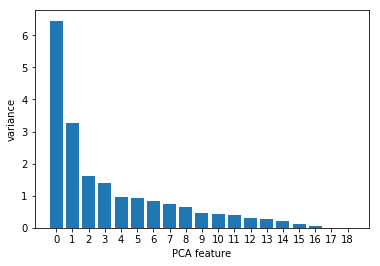

In [13]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scalar, pca)

pipeline.fit(features)

features_qty = range(pca.n_components_)
plt.bar(features_qty, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variância')
plt.xticks(features_qty)
plt.show()

Podemos assumir que com 4 componentes do PCA podemos uma quantidade de
informação para explicar os dados. A partir do quarto componente existe
uma variação muito baixa de variância indicando uma baixa agregação de
informação.

### Seleção das Variáveis

In [73]:
# seleção das variáveis para aplicat no tester.py
# a primeira variável necessita ser o poi
features_list = ['poi', 'exercised_stock_options', 'total_stock_value', 'bonus', 'salary']

In [74]:
# aloca em my_dataset sendo a variável esperada pelas funções
# fornecidas
my_dataset = data_dict

In [75]:
### extração dos dados utilizando funções fornecidas
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

### Pipelines dos modelos iniciais

Os dados apresentam grandes variações de magnitude, assim será aplicado um
escalonamento das variáveis nos pipelines para que não afete os modelos 
sensiveis a essas variações.

In [92]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [95]:
steps = [('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())]

pipeline = Pipeline(steps)

features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

pipeline.fit(features_train, labels_train)
pred = pipeline.predict(features_test)

print(classification_report(labels_test, pred))

cv_auc = cross_val_score(pipeline, features, labels, cv=5, scoring='roc_auc')
print(cv_auc)

             precision    recall  f1-score   support

        0.0       0.90      1.00      0.95        35
        1.0       0.00      0.00      0.00         4

avg / total       0.81      0.90      0.85        39

[ 0.7826087   0.55978261  0.42613636  0.72727273  0.50757576]


c:\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Aplicação de Classificadores

### Melhora do Modelo pelos Parâmetros

In [86]:
steps = [('scaler', StandardScaler()),
         ('SVM', SVC())]

pipeline = Pipeline(steps)

parameters = {'SVM__C':[1, 10, 100],
              'SVM__gamma':[0.1, 0.01]}

clf = GridSearchCV(pipeline, parameters, cv = 3)

clf.fit(features_train, labels_train)

pred = cv.predict(features_test)

print("Accuracy: {}".format(clf.score(features_test, labels_test)))
print(classification_report(labels_test, pred))
print("Tuned Model Parameters: {}".format(clf.best_params_))

Accuracy: 0.8974358974358975
             precision    recall  f1-score   support

        0.0       0.90      1.00      0.95        35
        1.0       0.00      0.00      0.00         4

avg / total       0.81      0.90      0.85        39

Tuned Model Parameters: {'SVM__C': 1, 'SVM__gamma': 0.01}


c:\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Salvar os Resultados 

In [ ]:
dump_classifier_and_data(clf, my_dataset, features_list)